In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit_129 as erk
import numpy as np
import pandas as pd

ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
risky_r = ind_return["2000":][["Steel","Fin","Beer"]]
risky_r.head()

,Steel,Fin,Beer
2000-01,-0.0277,-0.0442,-0.0228
2000-02,0.0684,-0.0849,-0.1164
2000-03,0.0349,0.1669,0.0013
2000-04,-0.0084,-0.0425,0.0368
2000-05,-0.0492,0.0506,0.1187


In [6]:
safe_r = pd.DataFrame().reindex_like(risky_r)

In [7]:
safe_r[:] = 0.03/12
start = 1000
floor = 0.8

In [8]:
def compound1(r):
    return (1+r).prod()-1

def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [9]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [10]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [11]:
  %timeit compound1(risky_r)

746 µs ± 105 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
  %timeit compound2(risky_r)

690 µs ± 133 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### CPPI

In [18]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3

In [19]:
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value-floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w,1)
    risky_w = np.maximum(risky_w,0)
    safe_w = 1 - risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    #update account value
    account_value = (risky_alloc*(1+risky_r.iloc[step])) + (safe_alloc*(1+safe_r.iloc[step]))
    cushion_history.iloc[step] = cushion
    account_history.iloc[step] = account_value
    risky_w_history.iloc[step] = risky_w

In [20]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


<Axes: >

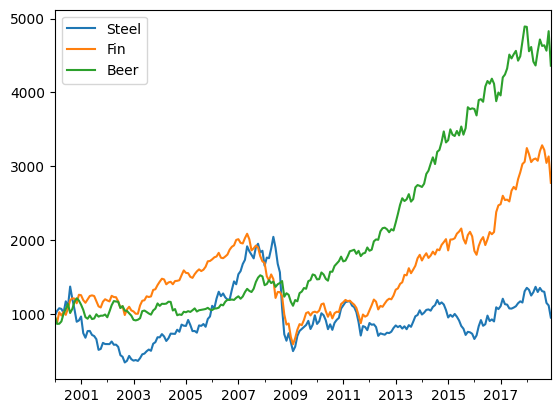

In [24]:
risky_wealth = start*(1+risky_r).cumprod()  # without applying cppi
risky_wealth.plot()

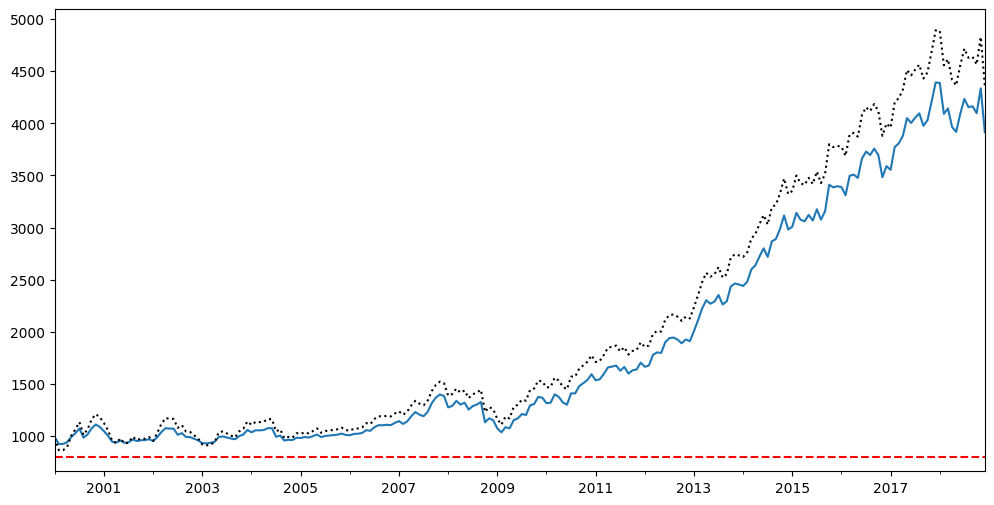

In [35]:
ax = account_history["Beer"].plot(figsize=(12,6))
risky_wealth["Beer"].plot(ax=ax,style="k:")         #without applying cppi
ax.axhline(y=floor_value,color="r",linestyle="--")

<Axes: >

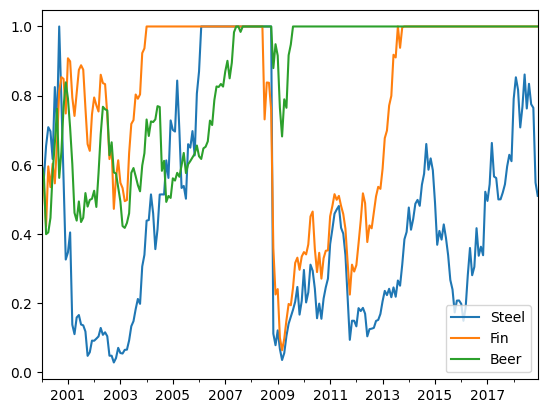

In [32]:
risky_w_history.plot()

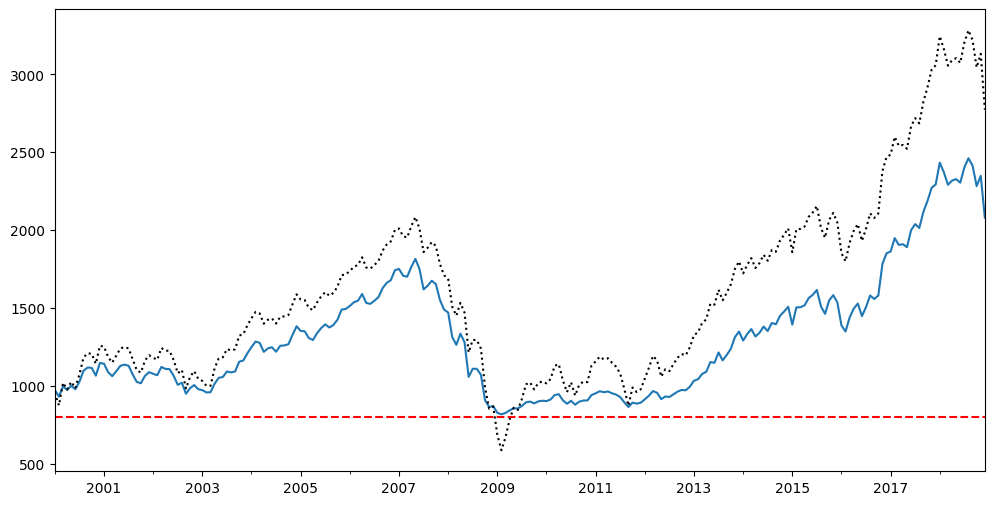

In [36]:
ind = "Fin"
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax,style="k:")         #without applying cppi
ax.axhline(y=floor_value,color="r",linestyle="--")

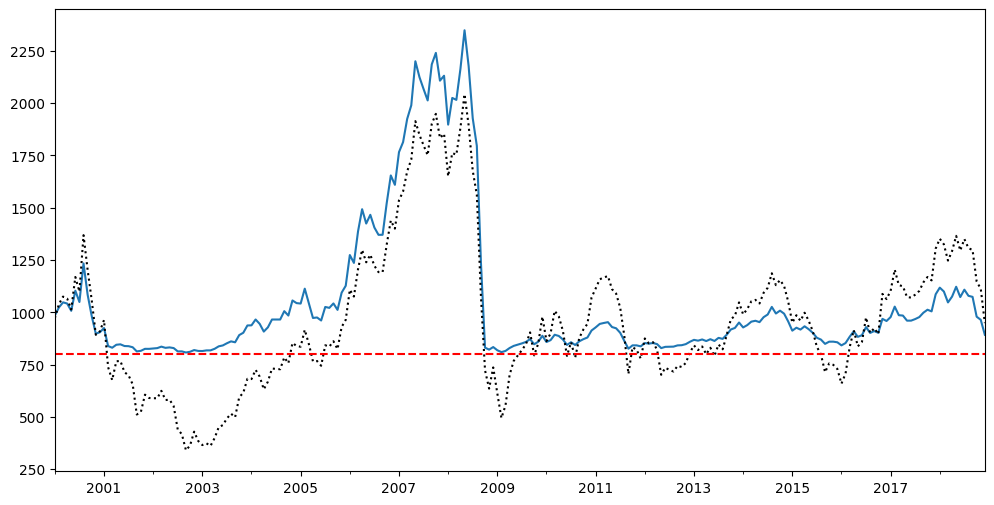

In [37]:
ind = "Steel"
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax,style="k:")         #without applying cppi
ax.axhline(y=floor_value,color="r",linestyle="--")

In [38]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [43]:
backtest_ret = erk.run_cppi(risky_r)   # with cppi
erk.summary_stats(backtest_ret["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


## Drawdown Constraint

In [45]:
backtest_ret1 = erk.run_cppi(ind_return["2007":][["Steel","Fin","Steel"]],drawdown=0.25)  # with cppi

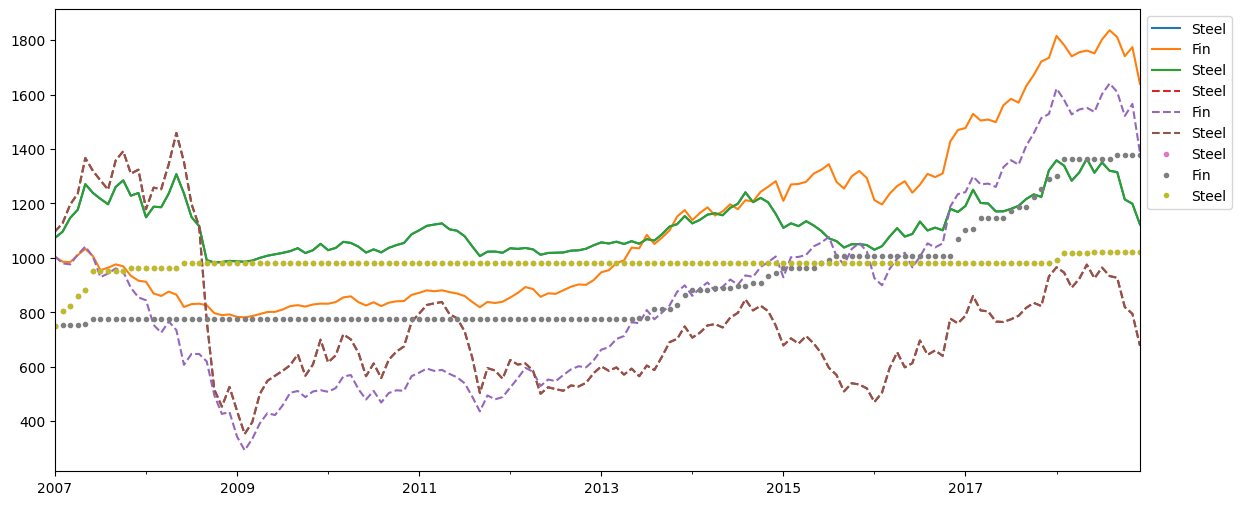

In [58]:
ax = backtest_ret1["Wealth"].plot(figsize=(14,6))
backtest_ret1["Risky Wealth"].plot(ax=ax,style="--")
backtest_ret1["floor"].plot(ax=ax,style=".").legend(bbox_to_anchor=(1, 1), loc='upper left')


In [48]:
erk.summary_stats(backtest_ret1["Risky Wealth"].pct_change().dropna()) # without cppi

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017


In [50]:
erk.summary_stats(backtest_ret1["Wealth"].pct_change().dropna()) # with 25% drowdown constraint

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059


Max drowdown is under 25%

<Axes: >

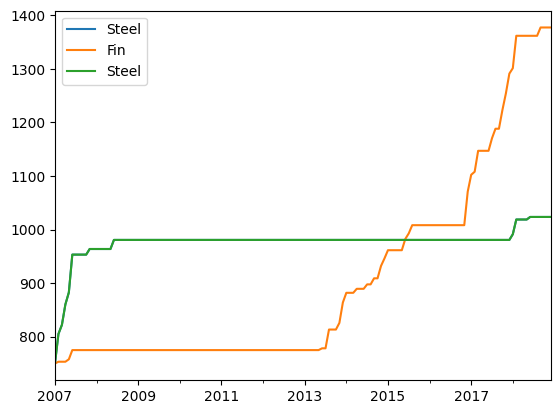

In [51]:
backtest_ret1["floor"].plot()